In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

df_birds = pd.read_csv("blackbird.csv")

print("setup and imports complete")

setup and imports complete


In [3]:
print("data frame shape: ",np.shape(df_birds))
df_birds.head()

data frame shape:  (4123, 10)


,Scheme,Ring number,Age,Sex,Wing,Weight,Day,Month,Year,Time
0,NOS,7453852,A,M,133.0,95.0,21,12,2006,14
1,BLB,23Z56852,A,M,134.0,106.0,25,11,2012,9
2,SFH,A559350,A,M,135.0,125.0,29,1,1994,9
3,SFH,A559350,A,M,135.0,113.0,5,2,1994,10
4,SFH,A559350,A,M,135.0,111.0,12,2,1994,8


In [14]:
df_freq_count = df_birds.groupby(['Ring number']).size().reset_index(name='count')
df_freq_count[df_freq_count['count'] > 1].sort_values(by=['count'], ascending=False).head(10)

,Ring number,count
2072,XP30643,24
346,CW42699,22
16,CL58437,21
208,CW42537,20
2125,XP30963,18
383,CW42751,18
1438,RJ36617,17
1597,RP31281,17
2043,RR11774,17
1845,RR11533,17


In [3]:
#method to list out missing values, and a percentage of the dataframe as a whole which is missing
def missingDataCount(df):
    missing_val_count = df.isnull().sum()
    missing_val_count.sort_values(ascending=False,inplace=True)
    total_cells = np.product(df.shape)
    total_missing = missing_val_count.sum()
    print (missing_val_count[0:10])
    print ("percent missing overall (out of 100) = ",(total_missing/total_cells) * 100)

missingDataCount(df_birds)

Wing           251
Weight          40
Time             0
Year             0
Month            0
Day              0
Sex              0
Age              0
Ring number      0
Scheme           0
dtype: int64
percent missing overall (out of 100) =  0.7057967499393646


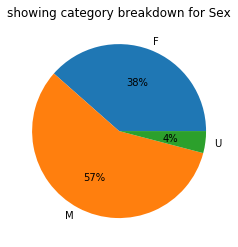

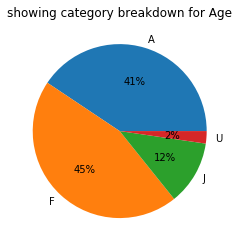

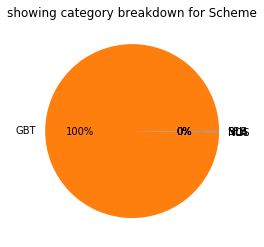

In [4]:
def categoryCheck(df,label):
    value_count = df[label].value_counts()
    df_values_counts = value_count.rename_axis('unique_values').reset_index(name='counts')
    categ_sums = df_values_counts.counts.groupby(df_values_counts.unique_values).sum()
    plt.pie(categ_sums,labels=categ_sums.index, autopct='%1.0f%%')
    plt.title("showing category breakdown for {0}".format(label))
    plt.show()

categoryCheck(df_birds,"Sex")
categoryCheck(df_birds,"Age")
categoryCheck(df_birds,"Scheme")

In [5]:
#imputed the missing values with the mean...maybe too much of an assumption
df_birds['Weight'].fillna(df_birds['Weight'].mean(), inplace=True)
df_birds['Wing'].fillna(df_birds['Wing'].mean(),inplace=True)

missingDataCount(df_birds)

Time           0
Year           0
Month          0
Day            0
Weight         0
Wing           0
Sex            0
Age            0
Ring number    0
Scheme         0
dtype: int64
percent missing overall (out of 100) =  0.0


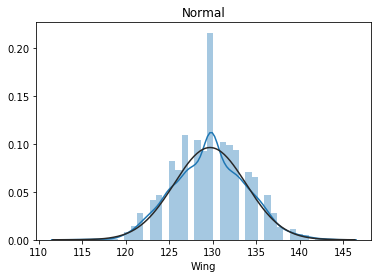

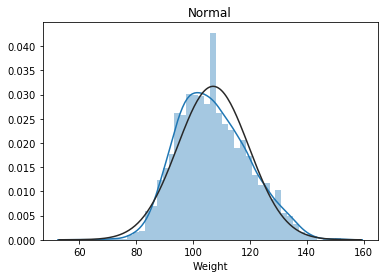

In [6]:
all_blackbird_features = ['Scheme','Ring number','Age','Sex','Wing','Weight','Day','Month','Year','Time']
blackbird_numeric_features = ['Wing','Weight']

for feature in blackbird_numeric_features:
    x = df_birds[feature]
    plt.figure(1); plt.title('Normal')
    sns.distplot(x, kde=True, fit=stats.norm)
    plt.show()

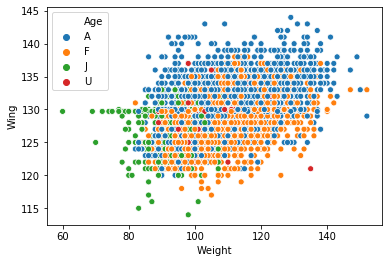

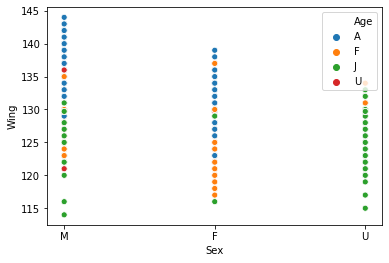

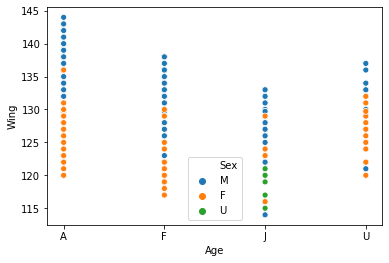

In [7]:
ax = sns.scatterplot(x="Weight", y="Wing", hue="Age",data=df_birds)
plt.show()
ax = sns.scatterplot(x="Sex", y="Wing", hue="Age",data=df_birds)
plt.show()
ax = sns.scatterplot(x="Age", y="Wing", hue="Sex",data=df_birds)

In [8]:
#visually we can see a lot of variance for the weight var so...measures of spread
df_birds['Weight'].describe()

count    4123.000000
mean      107.062944
std        12.577319
min        60.000000
25%        98.000000
50%       106.000000
75%       115.000000
max       152.000000
Name: Weight, dtype: float64

In [9]:
#change the categorical letters to discrete nominal and ordinal values respectively
#this is so they will work properly with models and such later on
le = LabelEncoder()
le.fit(df_birds['Sex'])
df_birds['Sex'] = le.transform(df_birds['Sex'])
print("Sex labels: ",le.classes_)
le = LabelEncoder()
le.fit(df_birds['Age'])
df_birds['Age'] = le.transform(df_birds['Age'])
print("Age labels: ",le.classes_)

Sex labels:  ['F' 'M' 'U']
Age labels:  ['A' 'F' 'J' 'U']


In [10]:
def build_correlate_graph(df_to_corr, features,correlate_for,corr_type):
    mydf = pd.DataFrame()
    mydf['feature'] = features
    mydf[corr_type] = [df_to_corr[f].corr(df_to_corr[correlate_for], corr_type) for f in features]
    mydf = mydf.sort_values(corr_type)
    print(mydf)
    plt.figure(figsize=(6, 0.25*len(features)))
    ax = sns.barplot(data=mydf, y='feature', x=corr_type, orient='h')
    ax.set_title("blackbird {0} correlations".format(corr_type))
    plt.ylabel('')
    plt.show()

  feature  spearman
4     Age -0.393657
6   Month -0.141272
3    Time -0.007027
5     Day -0.003749
7    Year  0.077251
1  Weight  0.391005
2     Sex  0.391072
0    Wing  1.000000


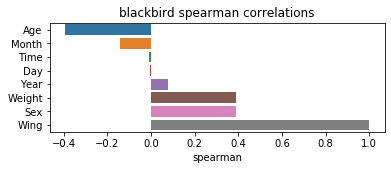

  feature   pearson
4     Age -0.367558
6   Month -0.081408
3    Time -0.022349
5     Day -0.006085
7    Year  0.096708
2     Sex  0.341328
1  Weight  0.388599
0    Wing  1.000000


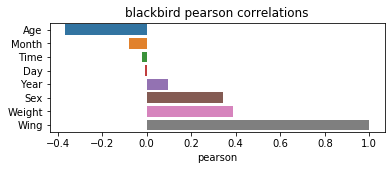

  feature   kendall
4     Age -0.315538
6   Month -0.104297
3    Time -0.005052
5     Day -0.002566
7    Year  0.054349
1  Weight  0.275529
2     Sex  0.323423
0    Wing  1.000000


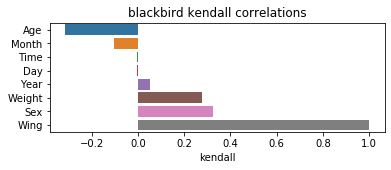

In [11]:
#do spearman, pearsons and kendall correlations
#No correlations for scheme because there is one scheme which account for {0} of the schemes involved"6/len(df_birds)
#No for Ring number, since it is just an identifier for the bird and not actually useful for prediction
blackbird_corr_features = ['Wing','Weight','Sex','Time','Age','Day','Month','Year']

build_correlate_graph(df_birds,blackbird_corr_features,'Wing','spearman')
build_correlate_graph(df_birds,blackbird_corr_features,'Wing','pearson')
build_correlate_graph(df_birds,blackbird_corr_features,'Wing','kendall')

#The most correlated features, in order: Weight, Age and Sex
#descision not to scale values since Sex cannot be scaled and only Weight and Age could be
#which is inconsistent overall

feature coefficients:  [0.12421828]
Regression y intercept:  116.44409307656312
linear regression mean squared error: 14, linear regression r squared: 0.1770844126747827


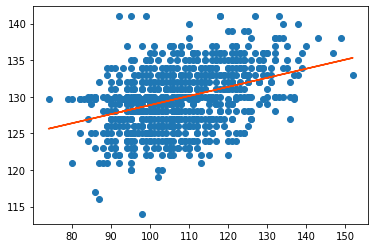

(825, 1) (825,)


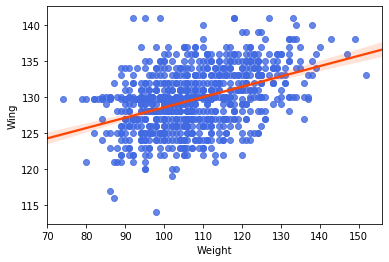

In [12]:
#here is the same code as below, but run only for the weight feature
#this has been done to allow for a comparison of having multiple features versus a single feature
#and weatehr or not the loss in accuracy is worth the extra transparency which this method provides
features = ['Weight']

X_train, X_valid, y_train, y_valid = train_test_split(df_birds[features], 
                                                      df_birds['Wing'], 
                                                      train_size=0.8, 
                                                      test_size=0.2,
                                                      random_state=0)

linear_reg_model = LinearRegression().fit(X_train, y_train)
lrg_predictions = linear_reg_model.predict(X_valid)

linear_reg_mse = int(mean_squared_error(y_valid, lrg_predictions))
linear_reg_r2 = r2_score(y_valid, lrg_predictions)

print("feature coefficients: ",linear_reg_model.coef_)
print("Regression y intercept: ",linear_reg_model.intercept_)
print("linear regression mean squared error: {0}, linear regression r squared: {1}"\
      .format(linear_reg_mse,linear_reg_r2))

plt.scatter(X_valid,y_valid)
plt.plot(X_valid,lrg_predictions,c='orangered')
plt.show()

print(np.shape(X_valid),np.shape(y_valid))
ax = sns.regplot(x=X_valid, y=y_valid,scatter_kws={"color": "royalblue"}, line_kws={"color": "orangered"})
ax.set(xlabel='Weight', ylabel='Wing')
plt.show()
#the regression line IS accurate, but the x values only start at ~80 as they are weights

In [13]:
#only features with correlations of +-0.1 are included, the other features are noise
features = ['Weight','Sex','Age','Month']

X_train, X_valid, y_train, y_valid = train_test_split(df_birds[features], 
                                                      df_birds['Wing'], 
                                                      train_size=0.8, 
                                                      test_size=0.2,
                                                      random_state=0)

linear_reg_model = LinearRegression().fit(X_train, y_train)
lrg_predictions = linear_reg_model.predict(X_valid)

linear_reg_mse = int(mean_squared_error(y_valid, lrg_predictions))
linear_reg_r2 = r2_score(y_valid, lrg_predictions)

print("multiple feature coefficients: ",linear_reg_model.coef_)
print("multiple Regression y intercept: ",linear_reg_model.intercept_)
print("multiple linear regression mean squared error: {0}, linear regression r squared: {1}"\
      .format(linear_reg_mse,linear_reg_r2))

#the feature coefficients would usually explain the expected change in Y for a change in value of 1 for X
#these are not so good for explaining the dependent variable, I think mostly because the variables are not scaled
#and cannot be scaled

#because I have used multiple variables in the prediction, it is now not possible to draw a single regression line
#this is because there are several feature coefficients and it would not be good to choose just one of them

multiple feature coefficients:  [ 0.10161241  3.2128281  -1.82095753 -0.05961929]
multiple Regression y intercept:  118.38457652992889
multiple linear regression mean squared error: 10, linear regression r squared: 0.42147575425055017


In [14]:
random_forest_reg = RandomForestRegressor(n_estimators=350, random_state=0)
random_forest_reg.fit(X_train,y_train)
random_forest_reg_pred = random_forest_reg.predict(X_valid)

random_forest_mse = int(mean_squared_error(y_valid, random_forest_reg_pred))
random_forest_r2 = r2_score(y_valid, random_forest_reg_pred)
print("Feature importances:",random_forest_reg.feature_importances_)
print("Random Forest regression mean squared error: {0}, Random forest regression r squared: {1}".format(random_forest_mse,random_forest_r2))

Feature importances: [0.33802529 0.27661673 0.26391595 0.12144204]
Random Forest regression mean squared error: 10, Random forest regression r squared: 0.4208653903469929
